# Exploratory Analysis Publisher Angle
> by Kristian Garza


In this exploration the first question we asked was how big is our dataset? We are looking at events that represents links between journal article and scholarly resources. Therefore our dataset looks like this: there are around 50K links from journal articles to scholarly resources and around 900K links from scholarly resources to journal articles.


In [130]:
library(ggplot2)
library(plyr)
library(scales)
library(dplyr)
library(stringr)
library(RColorBrewer)
library(httr)
library(tidyr)
library(psych)
library(reshape)
source("../functions/graph_functions.r")




subject,year,count,percentage,sum
copper,2006,32,79,5255
silver,2006,4176,79,5255


In [131]:
load("../data/2018-10-08_source_crossref_meta.Rda",verbose=TRUE)

registrants <- meta$registrants
citation_types <- meta$`citation-types`
relation_types <- meta$`relation-types`
pairings <- meta$pairings


Loading objects:
  meta


In [132]:
citation_types<-citation_types %>% unnest(`year-months`) 


In [133]:
flat_year<-function(years){
    x <- filter(years[[1]], title == "2017")
    return(x$sum)
}
flat_year_8<-function(years){
    x <- filter(years[[1]], title == "2018")
    return(x$sum)
}


for (row in 1:nrow(registrants)) {
    first <- flat_year(registrants$years[row])
    second <- flat_year_8(registrants$years[row])
    if(length(first) == 0){
        first<-0
    }
    if(length(second) == 0){
        second<-0
    }        
        
    registrants$`2017`[row] <- first
    registrants$`2018`[row] <- second
}

registrants<-registrants %>% 
    mutate(m=((`2018`-`2017`)/(10000)), client=title, 
           `2018-p`=100*(`2018`/count),
           `2017-p`=100*(`2017`/count) ,
           `2018`=`2018`,
           `2017`=`2017` 
          ) %>% 
    filter(startsWith(title, "crossref")) %>% arrange(desc(`2018`))


In [134]:

load("../data/2018-10-10_crossref_registrants.Rda",verbose=TRUE)
registrants <- registrants %>% rowwise() %>% left_join(crossref_reg)



Loading objects:
  crossref_reg


Joining, by = "id"


   vars n  mean     sd median trimmed   mad min max range skew kurtosis    se
X1    1 8 211.5 219.99    101   211.5 97.11  17 560   543 0.75     -1.4 77.78
   vars n mean     sd median trimmed   mad min max range skew kurtosis    se
X1    1 8  185 209.89   83.5     185 66.72  33 609   576 1.05    -0.67 74.21


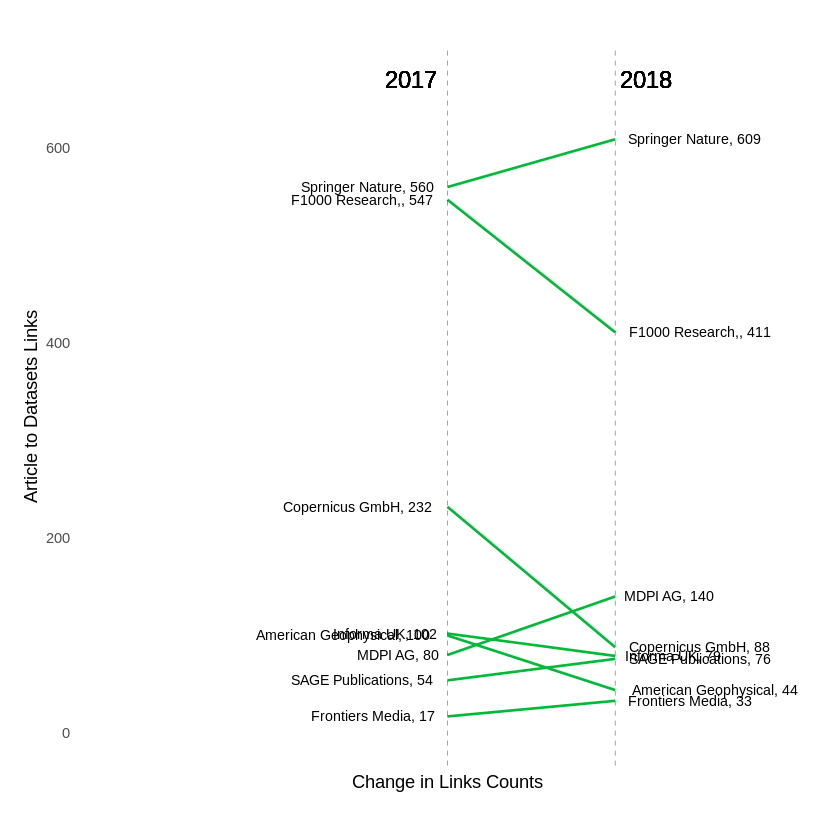

In [135]:
plot_slopegraph(y_label="Article to Datasets Links", slope_df=head(registrants,8))

# Relationships between Data Centers and Publishers

Another interesting thing we can look is relationships of citations between Publishers and Datacenters.

FIG Parallel set graph for data citations between particular Publishers and a particular Data Center. Publishers as the top category and Data Centers as the bottom category. The width of the bar denotes the absolute number of citations for that Publisher-Data center match. The dataset corresponds to links collected as of September 2018.


In [136]:
pairings<-pairings %>% unnest(registrants)


In [137]:
pairings<-pairings %>% filter(startsWith(title, "datacite")) %>% mutate(datacenter=as.factor(title),publisher=as.factor(id1))  %>%   
arrange(desc(sum))
# head(pairings,10)
# summary(pairings$count)

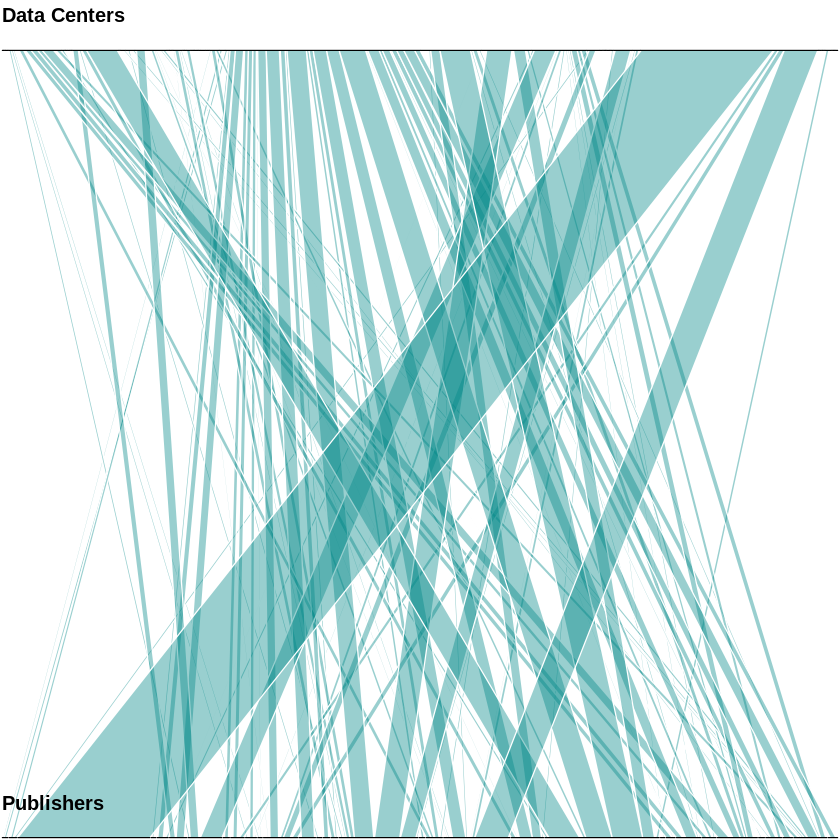

In [138]:
with(pairings, parallelset(publisher,datacenter,  freq=sum, col="#008888", alpha=0.4)) 

In [139]:
pairings <- meta$pairings
# head(pairings,2)
pairings<-pairings %>% unnest(registrants)  %>% filter(startsWith(title, "crossref")) %>% mutate(datacenter=as.factor(title1),publisher=as.factor(title)) %>% 
    arrange(desc(sum))
pairings <- pairings %>% rowwise() %>% left_join(crossref_reg)
# head(pairings,10)

# summary(pairings$count)

Joining, by = "id"


## Highlighting examples of Relationship between Datacenters and publishers

We highlight four examples:

- Springer Nature
- F1000Research
- Dryad


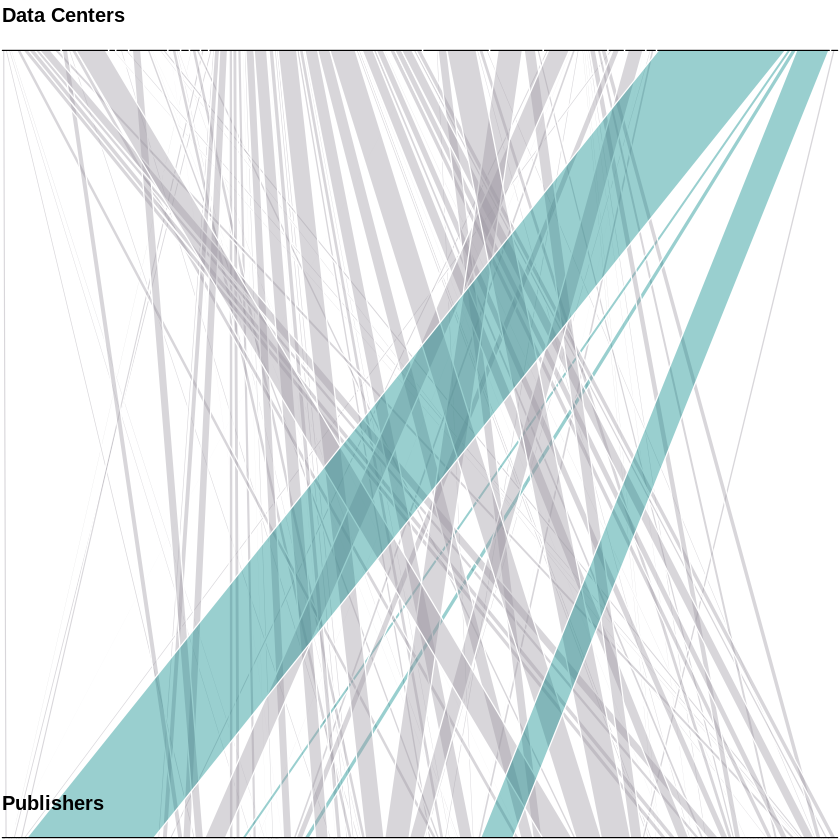

In [140]:
pairings_h <- pairings %>%
    mutate(highlighted = ifelse(publisher=="crossref.4950","Yes","No")) 
    

myt <- within(pairings_h, {
  highlighted <- factor(highlighted, levels=c("Yes","No"))
  color <- ifelse(highlighted=="Yes","#008888","#9e99a3")
})
with(myt, parallelset(publisher, datacenter,  freq=sum, col=color, alpha=0.4)) 

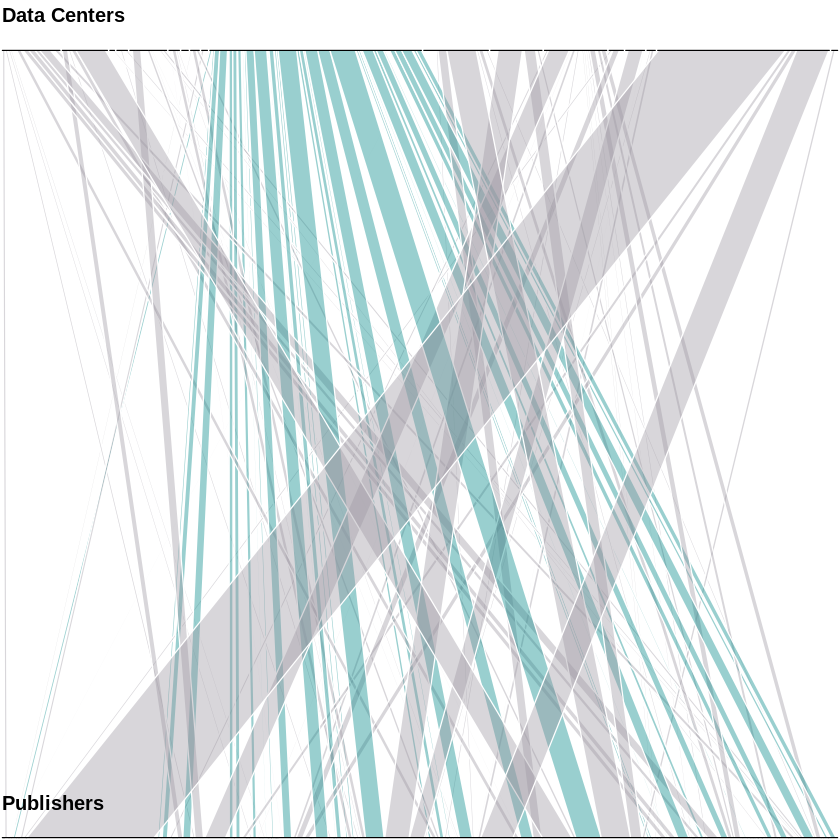

In [141]:
pairings_h <- pairings %>%
    mutate(highlighted = ifelse(publisher=="crossref.297","Yes","No")) 
    

myt <- within(pairings_h, {
  highlighted <- factor(highlighted, levels=c("Yes","No"))
  color <- ifelse(highlighted=="Yes","#008888","#9e99a3")
})
with(myt, parallelset(publisher, datacenter,  freq=sum, col=color, alpha=0.4)) 

# Types Distribution

   vars n mean sd median trimmed mad  min  max range skew kurtosis se
X1    1 1 6500 NA   6500    6500   0 6500 6500     0   NA       NA NA


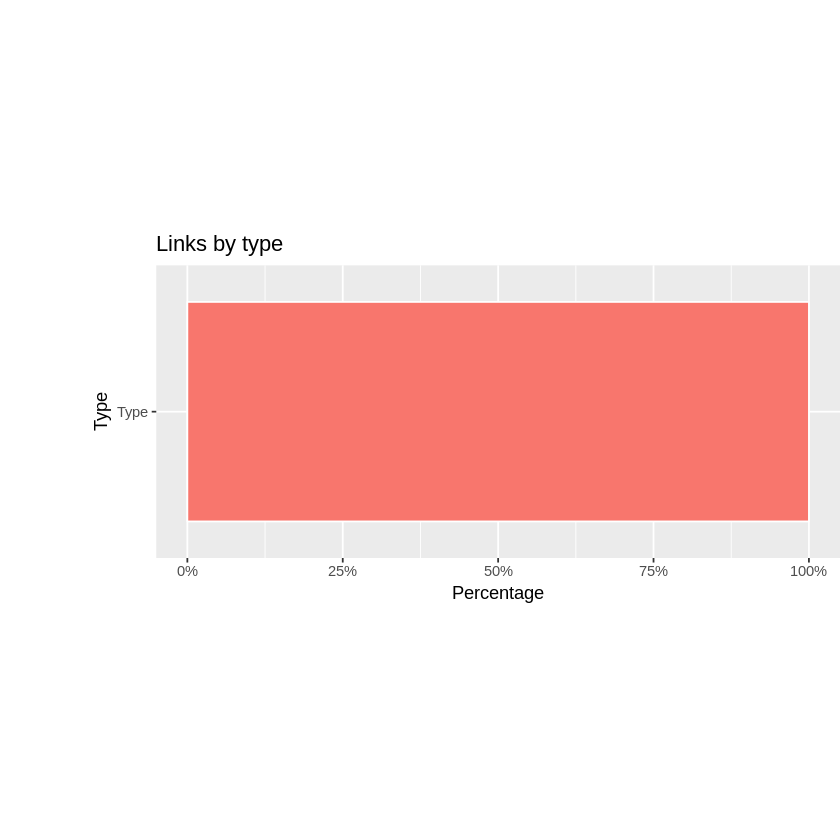

In [142]:
relation_types <- meta$`relation-types`

types <- relation_types %>%   
        mutate(total = sum(count), percentage = (count/total)*100, type=title, column="Type") %>%
        arrange(desc(total))


hundred_plot(types, "Links by type",FALSE)

In [143]:
load("../data/2018-10-09_source_crossref_all_citations_types_meta.Rda",verbose=TRUE)

Loading objects:
  meta


   vars n    mean       sd median trimmed     mad min   max range skew kurtosis
X1    1 7 6013.14 11007.86   1038 6013.14 1372.89 112 30452 30340 1.49     0.51
        se
X1 4160.58


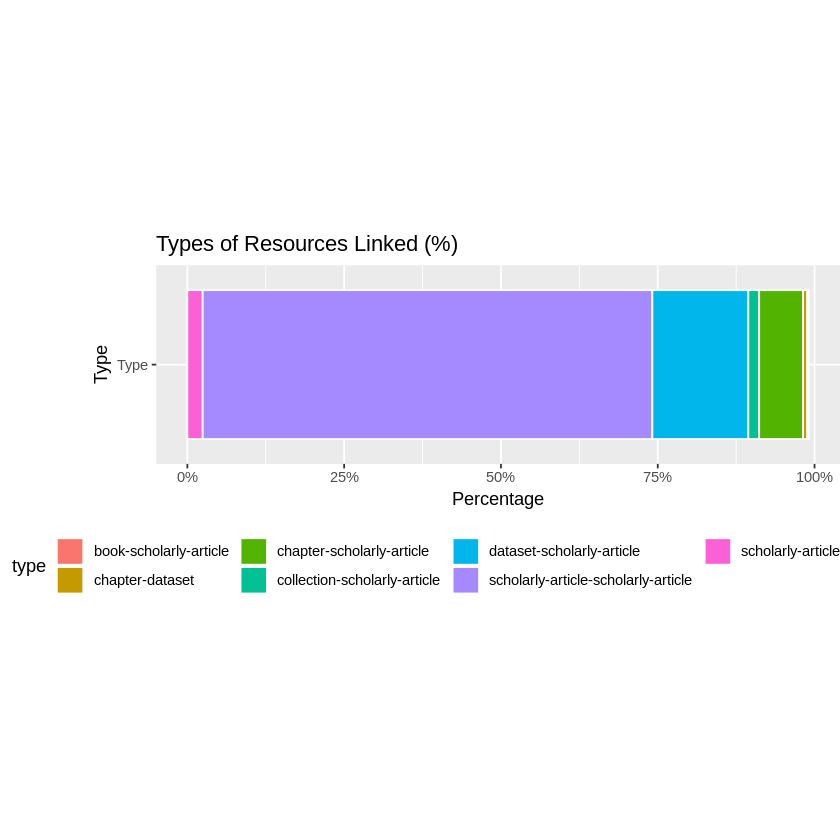

In [144]:
citation_types <- meta$`citation-types`

types <- citation_types %>%   
        mutate(total = sum(count), percentage = (count/total)*100, type=title, column="Type") %>%
        arrange(desc(percentage))
hundred_plot(head(types,7),"Types of Resources Linked (%)",TRUE)
# head(types)

# Links growth over the years

This is a distribution of between schilarly resources and article publications over the time. One might say that looks very small. But I think a better way to see it is by asking how has it change. Data citation is relatively new. Joint Declaration of Data Citation Principles was just release in 2014. We would like to know how things have change over the last couple years.

This is a distribution of data citations over the time. When we look at that growth we can see that since the Joint Declaration of Data Citation Principles the growth has been interesting, reaching around 40% increase every year with respect to the last year. 


In [145]:
load("../data/2018-10-08_source_crossref_meta.Rda",verbose=TRUE)
print((meta$registrants$years[1]))

registrants <- meta$registrants

Loading objects:
  meta
[[1]]
     id title sum
1  1990  1990   1
2  1994  1994   1
3  2002  2002   1
4  2003  2003   2
5  2004  2004   3
6  2010  2010   3
7  2011  2011   5
8  2012  2012   9
9  2013  2013  21
10 2014  2014  42
11 2015  2015  75
12 2016  2016 381
13 2017  2017 560
14 2018  2018 609



In [146]:
registrants<-registrants %>% unnest(`years`) %>% filter(id1>"2008") %>% mutate(year=as.factor(id1),sum=as.integer(sum))

x<-group_by(registrants, year) %>% summarise(total = sum(sum))

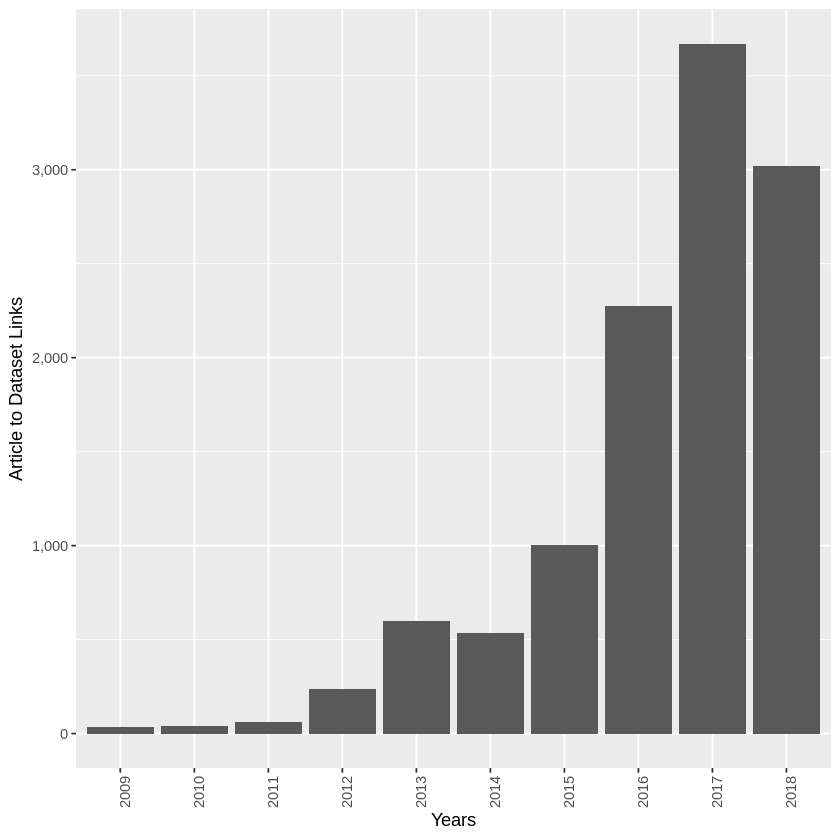

In [147]:
p<-ggplot(x, aes(x=year,y=total)) + geom_bar(stat="identity") + scale_y_continuous(label=comma) +
                      labs(x="Years", y="Article to Dataset Links")  # Axis labels


p + theme( 
              axis.text.x = element_text(angle = 90, hjust = 1)) 
